# Neural Network for DNA sequencing

This notebook demonstrates how to train a Neural Network on DNA data, 
make predictions for Transcription Factor Binding Sites (TFBS) and extract the learned motif with a simple gradient-based method.

# Load Necessary Libraries
These are libraries that will be used throughout the project.

In [20]:
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Dense, Flatten

from keras.models import Sequential

import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc, average_precision_score

from helper import IOHelper, SequenceHelper

import random
random.seed(1234)

# Load the sequence data

Our data set was generated from the files `data/ctcf.fa.gz` and `data/pu1.fa.gz`

In [21]:
input_fasta_data = IOHelper.get_fastas_from_file("data/pu1.fa.gz", uppercase=True)
sequence_length = len(input_fasta_data.sequence[0])
seq_matrix = SequenceHelper.do_one_hot_encoding(input_fasta_data.sequence, sequence_length,
                                                SequenceHelper.parse_alpha_to_seq)

In [22]:
# Helper Function that creates the negative set of examples
# by shuffling the positive examples
def do_dinucleotide_shuffling(X, size=1):
    x_shuffled = np.repeat(X, size, 0)

    for x in range(0, x_shuffled.shape[0]):
        random_index = np.arange(0, int(X.shape[1]/2))
        np.random.shuffle(random_index)
        for y in range(0, int(X.shape[1]/2)):
            x_shuffled[x,y*2, ] = X[int(x%X.shape[0]),random_index[y]*2]
            x_shuffled[x,(y*2)+1, ] = X[int(x%X.shape[0]),(random_index[y]*2)+1]

    return x_shuffled


seq_shuffled = do_dinucleotide_shuffling(np.array([[[e] for e in list(x)] for x in input_fasta_data.sequence]), size=1)
seq_shuffled = np.array(["".join(seq_shuffled[x, :, 0]) for x in range(seq_shuffled.shape[0])])
seq_shuffled_matrix = SequenceHelper.do_one_hot_encoding(seq_shuffled, sequence_length,
                                                         SequenceHelper.parse_alpha_to_seq)

## Create the Neural Network Architecture

Started with a fairly simple NN architeture of a single convolutional layer followed by a max-pooling layer
and then a single dense layer.

In [23]:

model = Sequential()
model.add(Conv2D(16, (12, 4), padding='valid', input_shape=(100, 4, 1),
                        activation='relu'))

model.add(MaxPooling2D(pool_size=(15,1), padding='valid'))

model.add(Flatten())
model.add(Dense(32, activation="relu"))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='mean_squared_error', optimizer='sgd')

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 89, 1, 16)         784       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 1, 16)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 80)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2592      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 3,409
Trainable params: 3,409
Non-trainable params: 0
_________________________________________________________________


## Create a test and a training subset
The data was split to 80% training set and a 20% test set.


In [24]:
# Create a random index
shuffling_index = np.arange(seq_matrix.shape[0] + seq_shuffled_matrix.shape[0])
np.random.shuffle(shuffling_index)

# Full data set Y ~ X where Y is a vector of 0s and 1s and X is the 
# corresponding sequence data
X = np.concatenate((seq_matrix, seq_shuffled_matrix))[shuffling_index, :, :]
X = np.nan_to_num(X)
Y = np.concatenate((np.ones(seq_matrix.shape[0]), np.zeros(seq_shuffled_matrix.shape[0])))[shuffling_index]

# Splitting the data into a training and a test set
X_train = X[0:int(X.shape[0]*0.8), :, :]
Y_train = Y[0:int(X.shape[0]*0.8)]

X_test = X[int(X.shape[0]*0.8):X.shape[0], :, :]
Y_test = Y[int(X.shape[0]*0.8):X.shape[0]]

print(X_train.shape)
print(Y_train.shape)

(45883, 100, 4)
(45883,)


In [25]:
# Reshaping the data so it corresponds to the input format of keras
# Keras is developed for image analysis so the 1 basically means 1 color channel
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

print(X_train_reshaped.shape)
print(X_test_reshaped.shape)

(45883, 100, 4, 1)
(11471, 100, 4, 1)


## Fit the Model

The NN was trained with a training set for 15 epochs. This test set was used to assess the actual training success after each epoch.



In [26]:
# You can play around with the batch_size, increasing it means that more examples are propagated 
# through the network at once
# epochs sets the number of full data iterations
model.fit(X_train_reshaped, Y_train,
          batch_size=10, epochs=15,
          validation_data=(X_test_reshaped, Y_test))


Epoch 1/15
4589/4589 [==============================] - 12s 3ms/step - loss: 0.2102 - val_loss: 0.1375
Epoch 2/15
4589/4589 [==============================] - 12s 3ms/step - loss: 0.1112 - val_loss: 0.0987
Epoch 3/15
4589/4589 [==============================] - 12s 3ms/step - loss: 0.0903 - val_loss: 0.0851
Epoch 4/15
4589/4589 [==============================] - 12s 3ms/step - loss: 0.0785 - val_loss: 0.0738
Epoch 5/15
4589/4589 [==============================] - 12s 3ms/step - loss: 0.0685 - val_loss: 0.0668
Epoch 6/15
4589/4589 [==============================] - 12s 3ms/step - loss: 0.0598 - val_loss: 0.0542
Epoch 7/15
4589/4589 [==============================] - 12s 3ms/step - loss: 0.0528 - val_loss: 0.0614
Epoch 8/15
4589/4589 [==============================] - 12s 3ms/step - loss: 0.0490 - val_loss: 0.0508
Epoch 9/15
4589/4589 [==============================] - 12s 3ms/step - loss: 0.0467 - val_loss: 0.0461
Epoch 10/15
4589/4589 [==============================] - 12s 3ms/step - l

## Evaluating the Model

After the NN was trained the test set was used to calculate the [AUC] and [AUPRC] (different combinations of the number of true and false predictions).

In [27]:
# The predictions are between 0 and 1 because of the sigmoid activation
# function of the last layer in the NN
pred = model.predict(X_test_reshaped, batch_size=32).flatten()
print("Predictions", pred[0:5])

# We can also calculate the AUC to get an estimate how good the NN actually learned
fpr, tpr, thresholds = roc_curve(Y_test, pred)
print("AUC", auc(fpr, tpr))
print("AUPRC", average_precision_score(Y_test, pred))

Predictions [0.81045485 0.670586   0.00453296 0.016177   0.19824705]
AUC 0.9849248330052991
AUPRC 0.983946560604459


## Make a motif plot:

In [28]:
# Plot the motif for the sequences 0 to 4
plot_index = range(0, 5)

# Get the Y ~ X for the sequences we want to plot
seq_matrix_for_plotting = seq_matrix.reshape((seq_matrix.shape[0], seq_matrix.shape[1], seq_matrix.shape[2], 1))[plot_index, :]
plotting_pred = model.predict(seq_matrix_for_plotting, batch_size=32).flatten()

#### Calculate Gradient

In [29]:
# Generate a new set of X where for each sequence every nucleotide is consecutively set to 0
tmp = np.repeat(seq_matrix_for_plotting, 100, axis=0)

a = np.ones((100, 100), int)
np.fill_diagonal(a, 0)
b = np.repeat(a.reshape((1,100,100)), seq_matrix_for_plotting.shape[0], axis=0)
c = np.concatenate(b, axis=0)
d = np.multiply(tmp, np.repeat(c.reshape((tmp.shape[0], 100, 1, 1)), 4, axis=2))

print(seq_matrix_for_plotting.shape)
print(d.shape)

(5, 100, 4, 1)
(500, 100, 4, 1)


In [30]:
# Calculate the prediction for each sequence with one deleted nucleotide
d_pred = model.predict(d, batch_size=32).flatten()

# Score: Difference between prediction and d_pred
scores = np.reshape((np.repeat(plotting_pred, 100) - d_pred), (len(plot_index),100))

# Score: Ratio between (1-d_pred) and (1-prediction)
# scores = np.reshape((1-d_pred)/(1-np.repeat(plotting_pred, 100))-1, (len(plot_index),100))

# Many more possibilities to calculate the score
# scores = ...

#### Make the Actual Plot

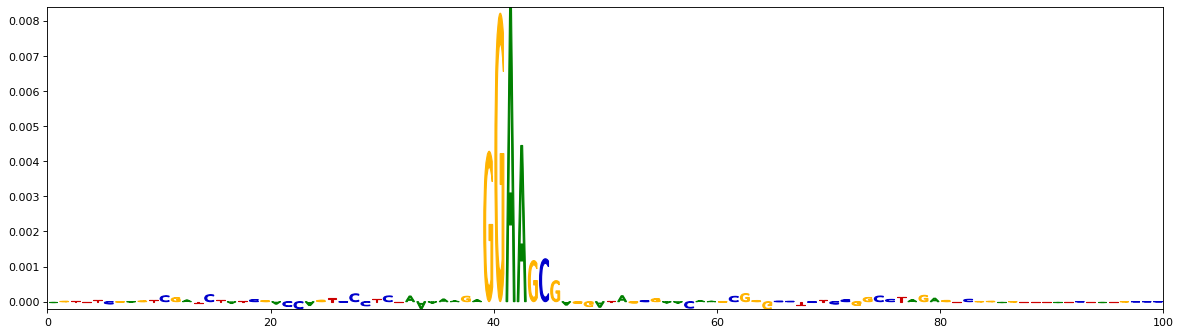

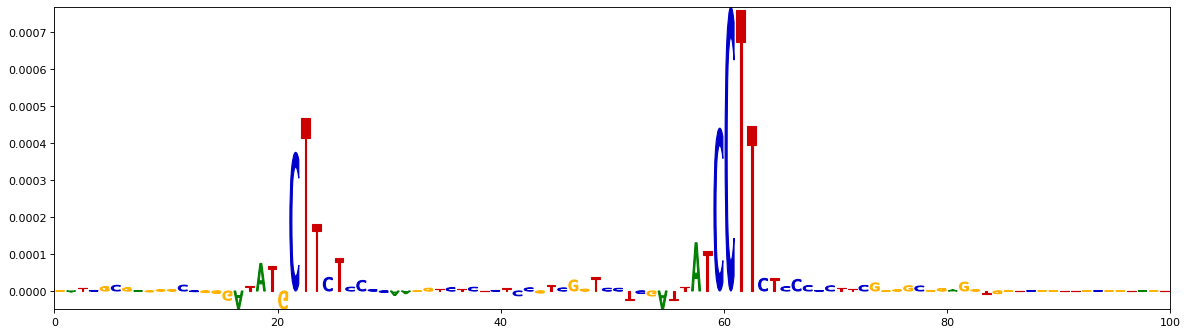

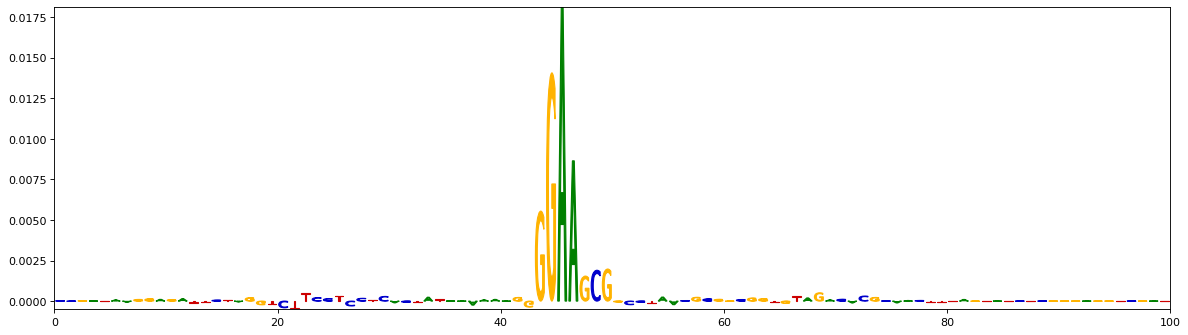

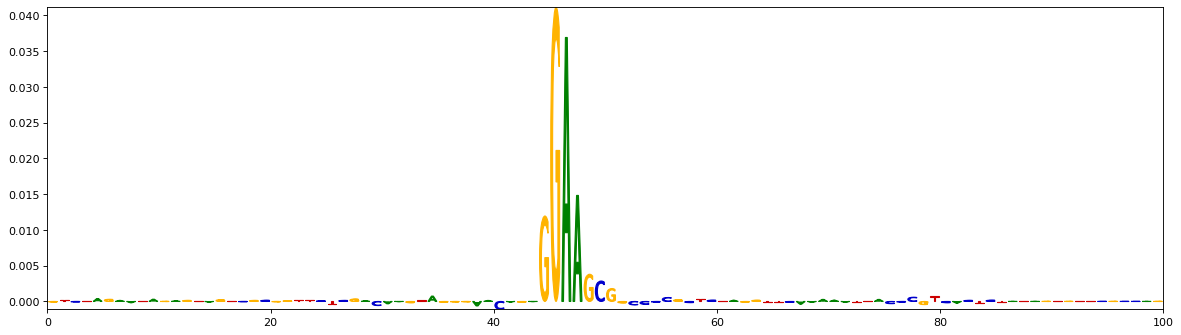

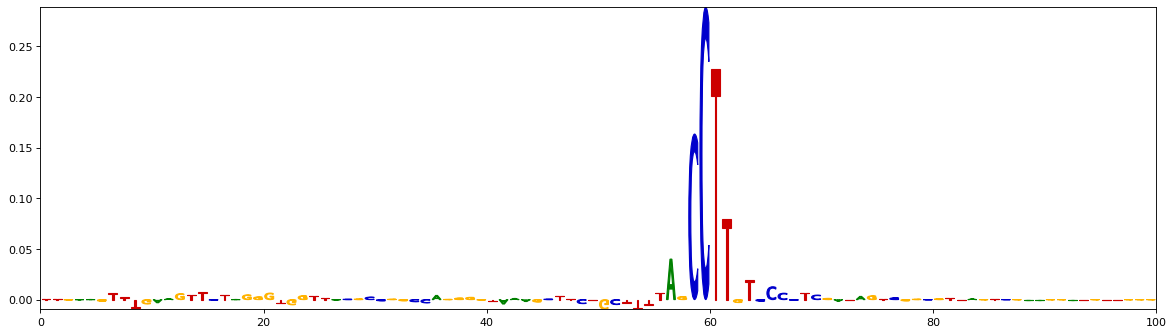

In [31]:
%matplotlib inline

import motif_plotter
import matplotlib.pyplot as plt

for idx in range(0,len(plot_index)):
    fig=plt.figure(figsize=(18, 5), dpi= 80)
    ax=fig.add_subplot(111)
    motif_plotter.make_single_sequence_spectrum(ax, 
                                                seq_matrix_for_plotting[idx].reshape((100, 4)),
                                                np.arcsinh(scores[idx]).reshape(100,1))
    plt.show()
